In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/train.zip' -d '/content/Ship_Classification'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Ship_Classification/images/2878298.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._2878298.jpg  
  inflating: /content/Ship_Classification/images/2806746.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._2806746.jpg  
  inflating: /content/Ship_Classification/images/627875.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._627875.jpg  
  inflating: /content/Ship_Classification/images/2802520.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._2802520.jpg  
  inflating: /content/Ship_Classification/images/2786205.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._2786205.jpg  
  inflating: /content/Ship_Classification/images/878940.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._878940.jpg  
  inflating: /content/Ship_Classification/images/2852471.jpg  
  inflating: /content/Ship_Classification/__MACOSX/images/._2852471.

In [ ]:
CSV_PATH = '/content/Ship_Classification/train.csv'
IMG_DIR = '/content/Ship_Classification/images/'

In [ ]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
df.columns = ['image', 'category']  
#df = df.sample(n=1000, random_state=42).reset_index(drop=True)
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Set inline plotting
%matplotlib inline

Dataset shape: (6252, 2)

Class distribution:
category
1    2120
5    1217
2    1167
3     916
4     832
Name: count, dtype: int64


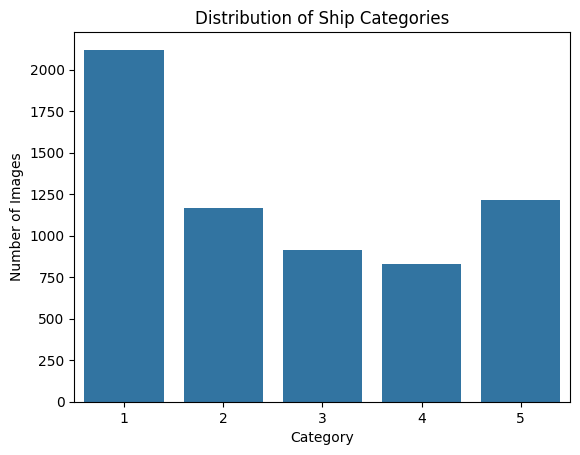

In [ ]:
print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['category'].value_counts())


sns.countplot(data=df, x='category')
plt.title('Distribution of Ship Categories')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
category_map = {
    1: 'Cargo',
    2: 'Military',
    3: 'Carrier',
    4: 'Cruise',
    5: 'Tanker'
}

df['class_name'] = df['category'].map(category_map)

Category 1: Cargo


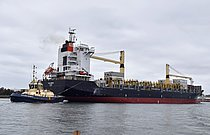

Category 2: Military


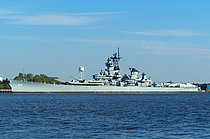

Category 3: Carrier


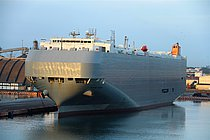

Category 4: Cruise


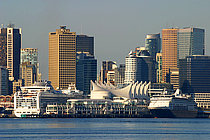

Category 5: Tanker


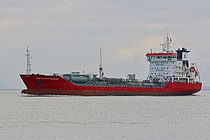

In [ ]:
import random
from IPython.display import Image as IPyImage, display

for cat in df['category'].unique():
    img_name = df[df['category'] == cat].sample(1)['image'].values[0]
    img_path = os.path.join(IMG_DIR, img_name)
    print(f"Category {cat}: {category_map[cat]}")
    display(IPyImage(img_path))

In [ ]:
img = Image.open(os.path.join(IMG_DIR, df.iloc[0]['image']))
print("Example image size:", img.size)

Example image size: (210, 140)


In [ ]:
df['category'] = df['category'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,             # normalize pixel values
    validation_split=0.2,       # split into training and validation
    shear_range=0.1,            # apply random shear
    zoom_range=0.2,             # apply random zoom
    horizontal_flip=True        # randomly flip images
)

In [ ]:
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col='image',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col='image',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 5002 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_vgg16_model(input_shape=(224, 224, 3), num_classes=5):
    
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    
    for layer in base_model.layers:
        layer.trainable = False

   
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    
    x = Flatten(name='flatten')(base_model.output)
    x = Dense(4096, activation='relu')(x)
    x = Dense(1072, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    
    model = Model(inputs=base_model.input, outputs=output)

    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_vgg16_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1072)           │     4,391,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,876,581 (464.92 MB)

 Trainable params: 114,241,317 (435.80 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
checkpoint = ModelCheckpoint('best_vgg16_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    verbose=1
)

In [ ]:
#from keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    restore_best_weights=True,
#    verbose=1
#)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5702 - loss: 1.1317
Epoch 1: val_loss improved from inf to 0.40207, saving model to best_vgg16_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 731ms/step - accuracy: 0.5711 - loss: 1.1290 - val_accuracy: 0.8152 - val_loss: 0.4021 - learning_rate: 1.0000e-04
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8687 - loss: 0.3373
Epoch 2: val_loss improved from 0.40207 to 0.27053, saving model to best_vgg16_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 98s 625ms/step - accuracy: 0.8688 - loss: 0.3372 - val_accuracy: 0.9128 - val_loss: 0.2705 - learning_rate: 1.0000e-04
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9249 - loss: 0.2039
Epoch 3: val_loss improved from 0.27053 to 0.25837, saving model to best_vgg16_model.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 151s 686ms/step - accuracy: 0.9248 - loss: 0.2040 - val_accuracy: 0.9040 - val_loss: 0.2584 - learning_rate: 1.0000e-04
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9421 - loss: 0.1500
Epoch 4: val_loss did not improve from 0.25837
157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 587ms/step - accuracy: 0.9421 - loss: 0.1500 - val_accuracy: 0.8920 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9559 - loss: 0.1274
Epoch 5: val_loss did not improve from 0.25837
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 578ms/step - accuracy: 0.9559 - loss: 0.1274 - val_accuracy: 0.8928 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9550 - loss: 0.1160
Epoch 6: val_loss did not improve from 0.25837

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 579ms/step - accuracy: 0.9550 - loss: 0

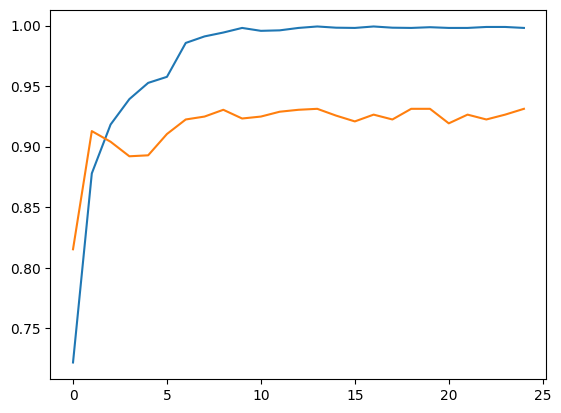

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_vgg16_model.h5')  

In [ ]:
%cd /content

/content


In [ ]:
!ls

best_vgg16_model.h5  drive  sample_data  Ship_Classification


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np


model = load_model('best_vgg16_model.h5')


img_path = 'cargo.jpg'
img = image.load_img(img_path, target_size=(224, 224)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0  

pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)[0]

print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: 0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


full_df = pd.read_csv('Ship_Classification/train.csv')


train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df['category'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)


In [ ]:
test_df['category'] = test_df['category'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory='Ship_Classification/images',
    x_col='image',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False  
)

Found 938 validated image filenames belonging to 5 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Predict
preds = model.predict(test_gen)
predicted_classes = np.argmax(preds, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step


In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93       318
           2       0.97      0.98      0.97       175
           3       0.99      0.96      0.98       138
           4       0.99      0.99      0.99       125
           5       0.90      0.92      0.91       182

    accuracy                           0.95       938
   macro avg       0.96      0.96      0.96       938
weighted avg       0.95      0.95      0.95       938

